In [12]:
import csv
import datetime
import math
import matplotlib
import os

import numpy as np
import pandas as pd

In [13]:
def date_calculate(current_date, years=None, monthes=None):
    target_date = None
    if(years):
        current_year = int(current_date.strftime('%Y'))
        target_year = current_year - years
        target_date = str(target_year) + '-' + current_date.strftime('%m-%d')
        target_date = datetime.datetime.strptime(target_date, '%Y-%m-%d')
    return target_date

In [14]:
def load_stock_data(year_period, end_date=None):
    # load n years ago data
    # If not assiment end date, using date of today
    start_date = date_calculate(datetime.date.today(), years=year_period).date()
    if(end_date):
        start_date = date_calculate(start_date, years=year_period).date()
    else:
        end_date = datetime.date.today()

    data = {}
    date = start_date
    n_days = (end_date - start_date).days
    for i in range(0, n_days):
        try:
            data[date] = pd.read_csv(os.path.join('stock', date.strftime('%Y%m%d') + '.csv')).set_index('證券代號')
            #print(date)
        except:
            None
        date += datetime.timedelta(days=1)
    return data

In [15]:
def get_close(lookback_period, end_date=None):
    raw_data = load_stock_data(lookback_period, end_date)
    data = pd.DataFrame({k:d['收盤價'] for k,d in raw_data.items()}).transpose()
    data.index = pd.to_datetime(data.index)
    return data

In [16]:
def get_strategy(data, start_date):
    prev_date = start_date - datetime.timedelta(365 * 3)
    c = data.truncate(prev_date.strftime('%Y-%m-%d'), start_date.strftime('%Y-%m-%d'))
    dropdown = (c.cummax() - c).max()/c.max() * 100 # 計算最大跌幅
    profit = (c.iloc[-1] / c.iloc[0] - 1) * 100 # 計算近n年報酬率
    std = (c/c.shift()).std() # 計算近n年標準差(波動率)
    # constraint
    # ----------
    constraint = (std[std < 0.02].index & 
                profit[profit > 10].index & 
                dropdown[dropdown < 50].index) 
    return constraint

In [17]:
def select_stock(data, constraint):
    # 依照剛剛的條件選取股票
    selected_stocks = constraint & data.columns
    # 過濾 收盤價 為 nan 的股票
    selected_stocks = [s for s in selected_stocks if not math.isnan(data[s].iloc[0])]
    print('選了',len(selected_stocks),'支股票')
    return selected_stocks

In [18]:
def backtest_init(cash, value, num_stock, first_close, ideal=True): # 現金 股票 選擇的股票數量 第一天收盤價 理想狀態
    # 回測
    print('現有資金:', cash)
    each_stock = [(cash / num_stock)] * num_stock # 每股可投入資金
    print("每張股票可投入資金:", each_stock[0])
    stocks_unit = [] # 持股張數
    # 分配股票
    for i in range(0, num_stock):
        if(ideal):
            number = each_stock[i] / (1.1 * first_close[i]) # 1.1 預設漲停
            stocks_unit.append(number)
            cash -= each_stock[i]
            value += each_stock[i]
        else:
            number = each_stock[i] // (1.1 * first_close[i])
            stocks_unit.append(number)
            cash -= number * (1.1 * first_close[i]) * (1 + 0.1425 * 0.01 * 0.6)
            value += number * (1.1 * first_close[i])
    print("購買 {0} 支股票\n".format(len([i for i in stocks_unit if i > 0])))
    return cash, value, stocks_unit

In [19]:
def backtest_run(cash, origin_cash, value, close, first_close, stocks_unit):
    # 進行回測
    last_close = first_close
    return_rate = [0] * len(close.index)
    for i in range(len(close.index)):
        cur_close = list(close.iloc[i])
        cur_value = 0
        for j in range(len(cur_close)):
            if math.isnan(cur_close[j]):
                cur_value += last_close[j] * stocks_unit[j]
            else:
                cur_value += cur_close[j] * stocks_unit[j]
                last_close[j] = cur_close[j]
        if(i == 0):
            cur_value = value
        return_rate[i] = (cur_value + cash) / origin_cash
    total_return = pd.Series(return_rate, index = close.index)
    print("本次投資報酬率:", return_rate[-1])
    return last_close, total_return

In [20]:
def backtest_end(cash, final_close, last_close, stocks_unit, ideal=True):
    # 回測結算
    final_value = 0
    for j in range(len(final_close)):
        if math.isnan(final_close[j]):
            final_close[j] = last_close[j]
        if(ideal):
            final_value += stocks_unit[j] * final_close[j] * (1 - 0.1425 * 0.01 * 0.6 - 0.3 * 0.01)
        else:
            final_value += stocks_unit[j] * final_close[j]
    cash += final_value
    print('結算後資金:', cash)
    return cash

In [21]:
%matplotlib inline
def backtest(start_date, end_date, hold_period, data, origin_cash):
    cash = origin_cash
    cash_ideal = origin_cash
    value = 0
    value_ideal = 0
    date_list = list(data.index.to_pydatetime())
    while(not start_date in date_list):
        start_date += datetime.timedelta(days=1)
    start_index = date_list.index(start_date)
    while((end_date - start_date).days > 0):
        constraint = get_strategy(data, start_date)
        next_date = start_date + datetime.timedelta(hold_period)
        print("================================================")
        print("\n開始日期: {0} \n結束日期: {1}".format(start_date.date(), next_date.date()))
        period_data = data.truncate(start_date.strftime('%Y-%m-%d'), next_date.strftime('%Y-%m-%d'))
        selected_stocks = select_stock(period_data, constraint)

        num_stock = len(selected_stocks)
        first_close = period_data[selected_stocks].iloc[0]
        final_close = list(period_data[selected_stocks].iloc[-1])

        # Real condition
        print("\n非理想狀況:")
        cash, value, stocks_unit = backtest_init(cash, value, num_stock, first_close, ideal=False)
        last_close, total_return = backtest_run(cash, origin_cash, value, period_data[selected_stocks], first_close, stocks_unit)
        cash = backtest_end(cash, final_close, last_close, stocks_unit, ideal=False)
        total_return.plot(color='red')
        value = 0

        # Ideal condition
        print("\n理想狀況:")
        cash_ideal, value_ideal, stocks_unit = backtest_init(cash_ideal, value_ideal, num_stock, first_close, ideal=True)
        last_close, total_return = backtest_run(cash_ideal, origin_cash, value_ideal, period_data[selected_stocks], first_close, stocks_unit)
        cash_ideal = backtest_end(cash_ideal, final_close, last_close, stocks_unit, ideal=True)
        total_return.plot(color='blue')
        value_ideal = 0
        
        start_date += datetime.timedelta(days=hold_period)

In [22]:
close = get_close(13)
close = close.apply(pd.to_numeric, errors='coerce', axis=0)


開始日期: 2010-01-04 
結束日期: 2010-03-05
選了 10 支股票

非理想狀況:
現有資金: 2000.0
每張股票可投入資金: 200.0
購買 10 支股票

本次投資報酬率: 0.9336302333999998
結算後資金: 1867.2604667999997

理想狀況:
現有資金: 2000.0
每張股票可投入資金: 200.0
購買 10 支股票

本次投資報酬率: 0.909090909090909
結算後資金: 1811.172727272727

開始日期: 2010-03-05 
結束日期: 2010-05-04
選了 10 支股票

非理想狀況:
現有資金: 1867.2604667999997
每張股票可投入資金: 186.72604667999997
購買 10 支股票

本次投資報酬率: 0.9198083367875
結算後資金: 1839.6166735749998

理想狀況:
現有資金: 1811.172727272727
每張股票可投入資金: 181.11727272727268
購買 10 支股票

本次投資報酬率: 0.8232603305785122
結算後資金: 1640.1733240082644

開始日期: 2010-05-04 
結束日期: 2010-07-03
選了 14 支股票

非理想狀況:
現有資金: 1839.6166735749998
每張股票可投入資金: 131.40119096964284
購買 14 支股票

本次投資報酬率: 0.8219373831124998
結算後資金: 1643.8747662249996

理想狀況:
現有資金: 1640.1733240082644
每張股票可投入資金: 117.15523742916174
購買 14 支股票

本次投資報酬率: 0.7455333290946655
結算後資金: 1485.3185962220105

開始日期: 2010-07-03 
結束日期: 2010-09-01
選了 9 支股票

非理想狀況:
現有資金: 1643.8747662249996
每張股票可投入資金: 182.65275180277774
購買 9 支股票

本次投資報酬率: 0.8249664481999998
結算後資金: 

本次投資報酬率: 0.5398746214049989
結算後資金: 1079.7492428099977

理想狀況:
現有資金: 185.07466759929093
每張股票可投入資金: 1.7968414330028246
購買 103 支股票

本次投資報酬率: 0.08412484890876869
結算後資金: 167.6010952324511

開始日期: 2014-02-12 
結束日期: 2014-04-13
選了 119 支股票

非理想狀況:
現有資金: 1079.7492428099977
每張股票可投入資金: 9.07352304882351
購買 1 支股票

本次投資報酬率: 0.5395609534549989
結算後資金: 1079.1219069099977

理想狀況:
現有資金: 167.6010952324511
每張股票可投入資金: 1.4084125649785806
購買 119 支股票

本次投資報酬率: 0.07618231601475041
結算後資金: 151.777266373027

開始日期: 2014-04-13 
結束日期: 2014-06-12
選了 122 支股票

非理想狀況:
現有資金: 1079.1219069099977
每張股票可投入資金: 8.845261532049161
購買 1 支股票

本次投資報酬率: 0.5401982478849988
結算後資金: 1080.3964957699977

理想狀況:
現有資金: 151.777266373027
每張股票可投入資金: 1.2440759538772705
購買 122 支股票

本次投資報酬率: 0.06898966653319423
結算後資金: 137.44742273741727

開始日期: 2014-06-12 
結束日期: 2014-08-11
選了 124 支股票

非理想狀況:
現有資金: 1080.3964957699977
每張股票可投入資金: 8.712874965887078
購買 0 支股票

本次投資報酬率: 0.5401982478849988
結算後資金: 1080.3964957699977

理想狀況:
現有資金: 137.44742273741727
每張股票可投入資金: 1.10

本次投資報酬率: 0.519688383007499
結算後資金: 1039.3767660149979

理想狀況:
現有資金: 17.126316293493826
每張股票可投入資金: 0.10771268109115614
購買 159 支股票

本次投資報酬率: 0.007784689224315413
結算後資金: 15.509358494711227

開始日期: 2018-01-22 
結束日期: 2018-03-23
選了 154 支股票

非理想狀況:
現有資金: 1039.3767660149979
每張股票可投入資金: 6.749199779318168
購買 1 支股票

本次投資報酬率: 0.519465385979999
結算後資金: 1038.930771959998

理想狀況:
現有資金: 15.509358494711227
每張股票可投入資金: 0.10071012009552745
購買 154 支股票

本次投資報酬率: 0.007049708406686902
結算後資金: 14.045063561558308

開始日期: 2018-03-23 
結束日期: 2018-05-22
選了 125 支股票

非理想狀況:
現有資金: 1038.930771959998
每張股票可投入資金: 8.311446175679984
購買 2 支股票

本次投資報酬率: 0.5185897900049989
結算後資金: 1037.1795800099978

理想狀況:
現有資金: 14.045063561558308
每張股票可投入資金: 0.11236050849246647
購買 125 支股票

本次投資報酬率: 0.0063841198007083015
結算後資金: 12.71901803775319

開始日期: 2018-05-22 
結束日期: 2018-07-21
選了 129 支股票

非理想狀況:
現有資金: 1037.1795800099978
每張股票可投入資金: 8.040151783023239
購買 2 支股票

本次投資報酬率: 0.518186952667499
結算後資金: 1036.373905334998

理想狀況:
現有資金: 12.71901803775319
每張股票可投入資金

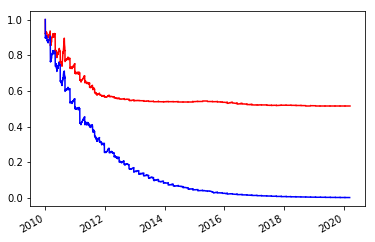

In [23]:
data = close
start_date = datetime.datetime(2010, 1, 1) 
end_date = datetime.datetime(2020, 2, 26) 
hold_period = 60
origin_cash = 2000000
backtest(start_date, end_date, hold_period, data, origin_cash / 1000)

# Test

In [56]:
from data import Data
d = Data()
d.load_data_from_pickle()
close = d.get_data()['volume']
res1 = close.iloc[-3]
#print(close.index)
result = ((close.iloc[-1] - close.iloc[-2]) / close.iloc[-2]) * 100
print(result)
print(result[result > 50].index)
'''
ma = d.get_data()['60ma']
res1 = close.iloc[-1]
res2 = ma.iloc[-1]
r = np.where(res1 > res2, True, False)
res = pd.Series(r, index=res1.index)
m = res[res == True].index
#print(res)
print(m)
print(len([t for t in r if t == True]))
'''

Load data from pickle file: C:\Users\Misty\Documents\Python Scripts\stock\stock_data.pickle
Load data finish!
1101       62.389122
1101B    4767.786391
1102       35.601667
1103      196.917470
1104       98.325950
1107             NaN
1108      -74.076374
1109      251.089411
1110       69.232308
1201      163.362522
1203      -16.270069
1210      323.622497
1213      -78.284680
1215      139.317454
1216       76.940663
1217      -44.495150
1218       -8.661055
1219      -91.473605
1220      -35.454468
1225       45.647981
1227      152.375035
1229      113.819737
1231      173.368573
1232       84.725523
1233       11.174299
1234      111.457952
1235       59.139130
1236       44.805247
1256      169.197464
1262             NaN
            ...     
9915             NaN
9917        1.731846
9918      211.950339
9919      -54.391271
9921       -5.138329
9922             NaN
9924      265.068318
9925      288.725444
9926      -73.754400
9927       73.839585
9928       19.180266
9929    

"\nma = d.get_data()['60ma']\nres1 = close.iloc[-1]\nres2 = ma.iloc[-1]\nr = np.where(res1 > res2, True, False)\nres = pd.Series(r, index=res1.index)\nm = res[res == True].index\n#print(res)\nprint(m)\nprint(len([t for t in r if t == True]))\n"